El objetivo de ese notebook es...

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/repo_tesis/entorno_tesis_Molina"
!source bin/activate

Mounted at /content/drive
/content/drive/My Drive/repo_tesis/entorno_tesis_Molina


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from joblib import load
from sklearn.model_selection import train_test_split
from sklearn import metrics
import sys

sys.path.append('/content/drive/My Drive/repo_tesis/lib')
import classes as cl

features = load("/content/drive/My Drive/repo_tesis/data/FEATURES_W200_I100.joblib")
label = load("/content/drive/My Drive/repo_tesis/data/label_W200_I100.joblib")

Voy a dividir los datos a mano de la siguiente forma.
Un sujeto repite cada gesto entre 5 y 6 veces. Voy a usar:
- Una repetición para test.
- Una para validacion.
- Las restantes para train.

En este sentido, voy a guardar los indices de label en listas distintas, para identificar luego que filas de FEATURES tengo que usar para cada conjunto de datos (train, val y test).

La implementación de esta idea parte del supuesto de que los gestos iguales estan agrupados, es decir, las repeticiones del mismo gesto son consecutivas.

In [6]:
# Preparo label para luego diff en el id del gesto para saber en que indices se cambia el gesto
label = np.array(label)

# Calculo los indices de label que son ventanas de reposo para trabajar con ellas por separado
ind_reposo = np.where(label[:, 0]==-1)[0]

# Calculo lo contrario ahora para facilitar obtener los labels de las ventanas con gestos
ind_gestos = np.where(label[:, 0]!=-1)[0]

label_gestos = label[ind_gestos, :]

# Hago el diff mencionado anteriormente
division_gestos = np.where(np.diff(label_gestos[:, 1])!=0)[0]

# Ahora hago un diff sobre la id de ventana para saber cuando cambia. Esto me va a servir para poder separarlo
# en train, val y test
division_id_ventanas = np.where(np.diff(label_gestos[:, 0])!=0)[0]

# Aca voy a guardar el id de la ventana
train = []
val = []
test = []

for i in range(len(division_gestos)):  #
    tope = division_gestos[i]   # este es limite con el proximo gesto

    if i==0:
        inicio = 0
        ind_inicio_ventana = 0

    else:
        inicio = division_gestos[i-1]
        ind_inicio_ventana = np.where(division_id_ventanas==inicio)[0][0]

    # busco en division_id_ventana cuantos elementos hay entre inicio y tope
    ind_tope_ventana = np.where(division_id_ventanas==tope)[0][0]

    # cantidad de repeticiones en el gesto actual (del sujeto actual)
    cant_ventanas = ind_tope_ventana - ind_inicio_ventana

    if i != 0:
        # sorteo las ventanas que van a cada grupo
        sorteo = np.random.permutation(cant_ventanas)
        sorteo += 1     # correccion de rango
    else:
        sorteo = np.random.permutation(cant_ventanas+1)
    # El primero va a test, el segundo a val y el resto a train
    test.append(ind_inicio_ventana + sorteo[0])
    val.append(ind_inicio_ventana + sorteo[1])
    for j in range(2, len(sorteo)):
        train.append(ind_inicio_ventana + sorteo[j])

A continuación se inserta un código de visualización. Fue usado para chequear que se estaba trabajando correctamente. Quizás pueda ser de utilidad en algún momento.

In [ ]:
# Quiero visualizar con diferentes colores las ventanas que van al train, val y test
# ventanas_train = []
# ventanas_val = []
# ventanas_test = []

# plt.figure()
# plt.plot(label[:, 1]/np.max(label[:, 1]), label = 'gesto')
# plt.plot(label[:, 0]/np.max(label[:, 0]), label = 'ventana')
# for i in range(len(train)): #
#     ventana_act_train = np.where(label[:, 0]==train[i])[0]
#     ventanas_train.append(ventana_act_train)
#     plt.plot(ventana_act_train, label[ventana_act_train, 0]/np.max(label[:, 0]), color = 'green')

#     if i < len(val):   # val y test tienen menos datos
#         ventana_act_val = np.where(label[:, 0]==val[i])[0]
#         ventanas_val.append(ventana_act_val)
#         plt.plot(ventana_act_val, label[ventana_act_val, 0]/np.max(label[:, 0]), color = 'blue')

#         ventana_act_test = np.where(label[:, 0]==test[i])[0]
#         ventanas_test.append(ventana_act_test)
#         plt.plot(ventana_act_test, label[ventana_act_test, 0]/np.max(label[:, 0]), color = 'black')

# plt.legend()

Procedo a armar los conjuntos de train, val y test para las ventanas con gesto.
Tengo identificada que repeticion va para cada conjunto, ahora identifico los indices de las features usando label.

In [7]:
# Guardo los indices de los datos de train
indices_train = []
for j in range(len(train)):
    indices_train.extend(np.where(label[:, 0]==train[j])[0])

# Guardo los indices de los datos de val
indices_val = []

# Guardo los indices de los datos de test
indices_test = []

for j in range(len(val)):
    indices_val.extend(np.where(label[:, 0]==val[j])[0])
    indices_test.extend(np.where(label[:, 0]==test[j])[0])

#%% Ahora agrego las ventanas de reposo
# primero sorteo para que me queden mejor distribuidas en cada conjunto
cant_features_reposo = len(ind_reposo)
sorteo = np.random.permutation(cant_features_reposo)
cant_train = (2*cant_features_reposo)//3    # aproximadamente el mismo porcentaje que se manda de cada gesto
cant_test = (168*cant_features_reposo)//1000  # lo mismo, aprox 16,8%

ind_train_reposo = ind_reposo[sorteo[:cant_train]]
ind_test_reposo = ind_reposo[sorteo[cant_train:cant_train+cant_test]]
ind_val_reposo = ind_reposo[sorteo[cant_train+cant_test:]]

# Agrego los indices de reposo a las listas que ya tenia
# Train
indices_train.extend(ind_train_reposo)

# Validacion
indices_val.extend(ind_val_reposo)

# Test
indices_test.extend(ind_test_reposo)

Habiendo calculado los índices, prosigo a armar los conjuntos, extrayendo las features y labels asociados a los índices calculados para cada conjunto de datos.

In [8]:
# lo paso a numpy array para poder definir de forma mas comoda los conjuntos de train test y val
features = np.array(features)


X_train = features[indices_train, :]
y_train = label[indices_train, 1]
X_val = features[indices_val, :]
y_val = label[indices_val, 1]
X_test =  features[indices_test, :]
y_test = label[indices_test, 1]

Entreno una red neuronal de arquitectura 80-250-80.


In [56]:
import time
# Quiero calcular el tiempo que demora en entrenarse el algoritmo
start_time = time.time()

# Parametros de entrada de la red neuronal que tenemos que definir
# Definimos a mano la cantidad de features
featureNum = 15
chNum = 16
# Numero de columnas que va a haber en features
inputDim = chNum*featureNum
# Numero de gestos contando el reposo
clasNum = np.max(label[:, 1]) + 1

# Architecture 80 - 250 - 80
red = cl.Clasificador(model= "mlp", arch = [80,250,80], catNum = clasNum, featureNum = inputDim)
red.train(X_train, y_train, X_val, y_val)

end_time = time.time()
training_time = end_time - start_time

# Calculo las etiquetas predecidas por el modelo
y_pred = red.predict(X_test)


Epoch 1/50
1322/1322 [==============================] - 5s 3ms/step - loss: 1.8228 - accuracy: 0.3642 - val_loss: 1.7277 - val_accuracy: 0.3810
Epoch 2/50
1322/1322 [==============================] - 4s 3ms/step - loss: 1.5597 - accuracy: 0.4518 - val_loss: 1.5832 - val_accuracy: 0.4477
Epoch 3/50
1322/1322 [==============================] - 3s 3ms/step - loss: 1.4500 - accuracy: 0.4914 - val_loss: 1.6461 - val_accuracy: 0.4368
Epoch 4/50
1322/1322 [==============================] - 3s 2ms/step - loss: 1.3704 - accuracy: 0.5201 - val_loss: 1.5736 - val_accuracy: 0.4545
Epoch 5/50
1322/1322 [==============================] - 5s 4ms/step - loss: 1.3096 - accuracy: 0.5452 - val_loss: 1.4774 - val_accuracy: 0.4969
Epoch 6/50
1322/1322 [==============================] - 3s 2ms/step - loss: 1.2457 - accuracy: 0.5695 - val_loss: 1.4940 - val_accuracy: 0.4969
Epoch 7/50
1322/1322 [==============================] - 3s 2ms/step - loss: 1.1978 - accuracy: 0.5830 - val_loss: 1.4791 - val_accuracy:

Voy a guardar el clasificador, y evaluar distintas métricas: accuracy, precision y recall. También voy a hacer una matriz de confusión.

170/170 [==============================] - 0s 2ms/step
Accuracy: 0.5729262460915946
Precision: 0.5936868818377671
Recall: 0.5729262460915946


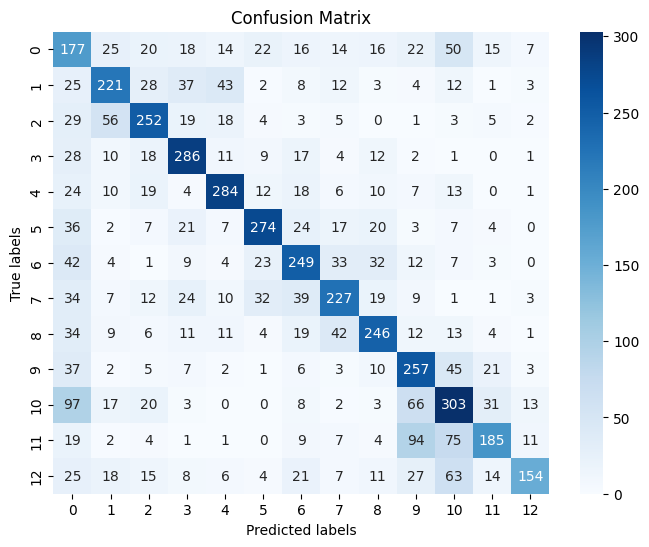

<Figure size 640x480 with 0 Axes>

In [61]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import joblib
import seaborn as sns

# Guardar el modelo entrenado en un archivo
joblib.dump(red, 'renato_mlp_80_250_80_sep_rep_W200_I100.pkl')

# Predecir en el conjunto de test
y_pred = red.predict(X_test)

# Calcular métricas de desempeño
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Mostrar las métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Guardar la imagen de la matriz de confusión
plt.savefig("confusion_matrix.png")

Voy a guardar las métricas calculadas en un experimento en Comet

In [58]:
#!pip install comet_ml

In [62]:
from comet_ml import Experiment
# Conectar con Comet
API_KEY = 'ehXeElNypcj7Knar5zTmyjwSO' # Se puede encontrar en Settings(Arriba a la derecha en Comet)

# Crear un experimento con mi API KEY
exp = Experiment(api_key=API_KEY,
                 project_name='tesis-experimentos', # Nombre del proyecto donde se registran los experimentos
                 auto_param_logging=False)
exp.set_name('renato_mlp_80_250_80_sep_rep_W200_I100') # Nombre de este experimento
exp.add_tags(['renato', 'mlp', '80_250_80', 'W200_I100', 'sep_rep']) # Tags

exp.log_metric("accuracy", accuracy)
exp.log_metric("precision", precision)
exp.log_metric("recall", recall)
exp.log_metric("training_time", training_time)
exp.log_confusion_matrix(y_test, y_pred)


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: tensorboard, sklearn, keras, lightgbm, tensorflow.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/manuelmolinach99/tesis-experimentos/dbddafb537b342ef91a3e32d1f6d83df



{'web': 'https://www.comet.com/api/asset/download?assetId=c79da511dc3b43819c706e32a0000e11&experimentKey=dbddafb537b342ef91a3e32d1f6d83df',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=c79da511dc3b43819c706e32a0000e11&experimentKey=dbddafb537b342ef91a3e32d1f6d83df',
 'assetId': 'c79da511dc3b43819c706e32a0000e11'}

In [63]:
# Subir el modelo
exp.log_model(name="renato_mlp_80_250_80_sep_rep_W200_I100", file_or_folder="renato_mlp_80_250_80_sep_rep_W200_I100.pkl")
exp.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/manuelmolinach99/tesis-experimentos/dbddafb537b342ef91a3e32d1f6d83df
COMET INFO:   Metrics:
COMET INFO:     accuracy      : 0.5729262460915946
COMET INFO:     precision     : 0.5936868818377671
COMET INFO:     recall        : 0.5729262460915946
COMET INFO:     training_time : 216.45979762077332
COMET INFO:   Others:
COMET INFO:     Name : renato_mlp_80_250_80_sep_rep_W200_I100
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix         : 1
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (86.02 K